In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

C:\Users\changjun\anaconda3\envs\tf_gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\changjun\anaconda3\envs\tf_gpu\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\changjun\anaconda3\envs\tf_gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
tf.random.set_seed(123)

In [3]:
WIDTH = 28
HEIGHT = 28

def make_grid(images, nrow=5):
    n, h, w = images.shape
    ncol = (int)(n / 5)
    grid = np.zeros((ncol*h, nrow*w))

    idx = 0
    for i in range(ncol):
        for j in range(nrow):
            grid[HEIGHT*i:HEIGHT*(i+1), WIDTH*j:WIDTH*(j+1)] = images[idx]
            idx += 1
    
    return grid

def show_tensor_images(image_tensor, num_images=25):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = tf.squeeze(image_tensor.numpy())#.reshape(-1, HEIGHT, WIDTH)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid, cmap='gray')
    plt.show()

def get_noise(n_samples, z_dim):
    return tf.random.normal([n_samples, z_dim])

In [4]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
w_init = tf.keras.initializers.RandomNormal(0.0, 0.02)
b_init = tf.keras.initializers.Constant(0)

## Generator

In [6]:
class Generator(keras.Model):
    '''
    Generator Class
    Params:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        
        self.gen = keras.Sequential([
            keras.layers.Input((1, 1, z_dim)),
            self.make_gen_block(hidden_dim * 4),
            self.make_gen_block(hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim),
            self.make_gen_block(im_chan, kernel_size=4, final_layer=True),
        ])
    
    def make_gen_block(self, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        ocrresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Params:
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise (affects activation and batchnorm)
        '''
        if not final_layer:
            return keras.Sequential([
                keras.layers.Conv2DTranspose(output_channels, kernel_size, stride,
                                            kernel_initializer=w_init),
                keras.layers.BatchNormalization(),
                keras.layers.LeakyReLU(0.2)
            ])
        else:
            return keras.Sequential([
                keras.layers.Conv2DTranspose(output_channels, kernel_size, stride,
                                            kernel_initializer=w_init),
                keras.layers.Activation('tanh')
            ])
    
    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Params:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return tf.reshape(noise, (len(noise), 1, 1, self.z_dim))
    
    def call(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

## Discriminator

In [7]:
class Discriminator(keras.Model):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        
        self.disc = keras.Sequential([
            keras.layers.Input((WIDTH, HEIGHT, im_chan)),
            self.make_disc_block(hidden_dim),
            self.make_disc_block(hidden_dim * 2),
            self.make_disc_block(1, final_layer=True),
        ])
    
    def make_disc_block(self, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise (affects activation and batchnorm)
        '''
        if not final_layer:
            return keras.Sequential([
                keras.layers.Conv2D(output_channels, kernel_size, stride,
                                            kernel_initializer=w_init),
                keras.layers.BatchNormalization(),
                keras.layers.LeakyReLU(0.2),
                keras.layers.Dropout(0.3),
            ])
        else:
            return keras.Sequential([
                keras.layers.Conv2D(output_channels, kernel_size, stride,
                                            kernel_initializer=w_init),
            ])
    
    def call(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return tf.reshape(disc_pred, (len(disc_pred), -1))

## Training

In [8]:
BCELoss = keras.losses.BinaryCrossentropy(from_logits=True)
z_dim = 64
display_step = 500
batch_size = 128
learning_rate = 0.0001

# Parameter for optimizer's momentum
beta_1 = 0.5
beta_2 = 0.999

def map_fn(x, y):
    x = tf.cast(x, tf.float32)
    x = (x - 127.5) / 127.5 # normalization between -1 and 1
    
    return x

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(map_fn).shuffle(1024).batch(batch_size)

In [9]:
gen = Generator(z_dim)
gen_opt = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
disc = Discriminator()
disc_opt = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.6022929309010506, Discriminator loss: 0.7286525478363041


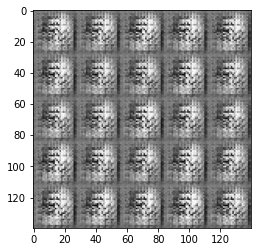

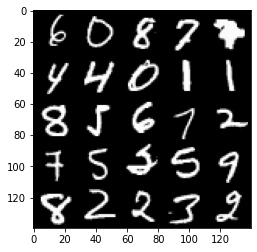

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 0.8604227216243748, Discriminator loss: 0.5689842804074293


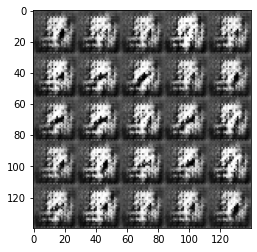

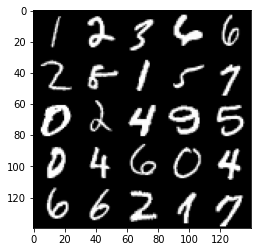

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 0.8174870440959936, Discriminator loss: 0.6367008422613141


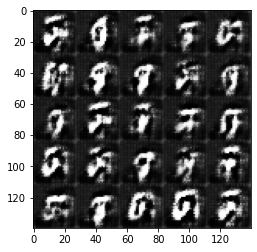

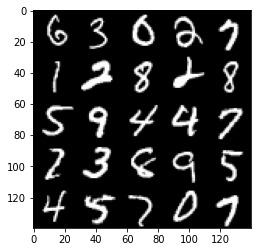

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 0.7786675804853443, Discriminator loss: 0.6669278023242954


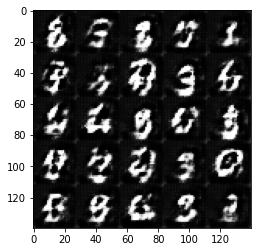

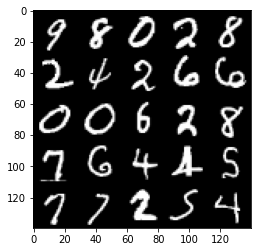

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 0.7681628773212436, Discriminator loss: 0.6624475736618046


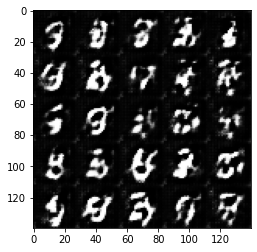

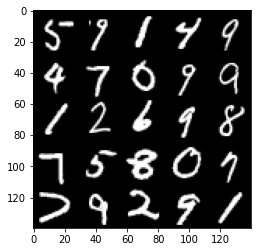

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 0.7718752096891406, Discriminator loss: 0.6588059550523762


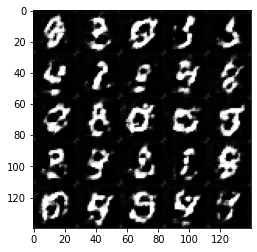

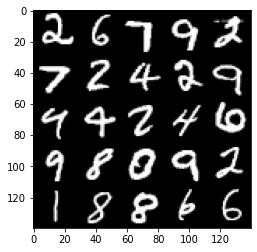

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 0.7693017044067381, Discriminator loss: 0.6602306598424916


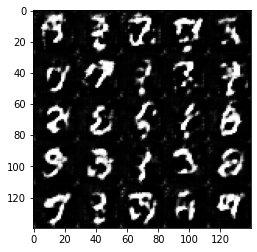

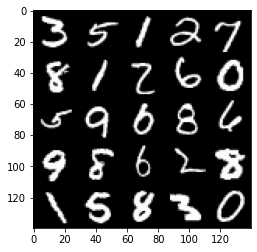

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 0.7670867010355, Discriminator loss: 0.6632557338476179


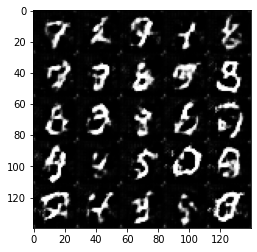

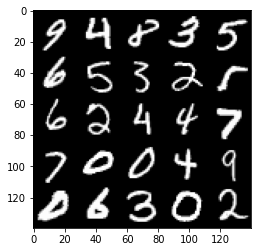

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 0.7642754495143887, Discriminator loss: 0.663903757691383


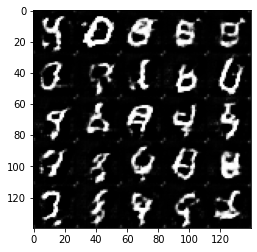

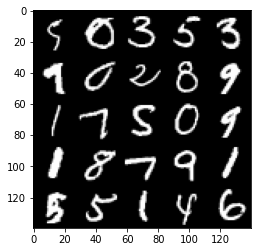

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 0.7569766423702232, Discriminator loss: 0.6673708748817436


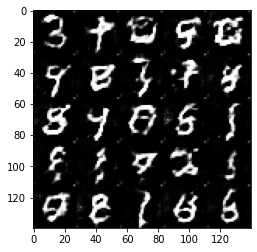

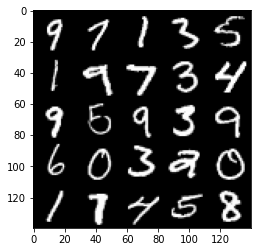

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 0.7541982717514045, Discriminator loss: 0.6687701652050025


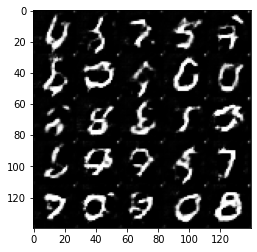

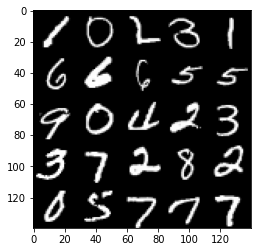

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 0.7520901968479148, Discriminator loss: 0.6707075450420378


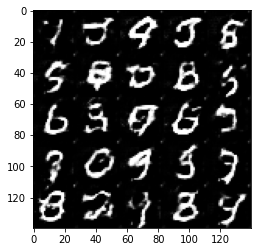

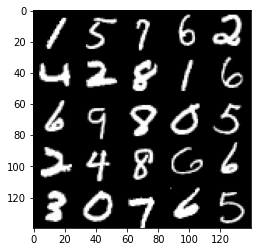

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 0.7495187786817553, Discriminator loss: 0.6728511748313903


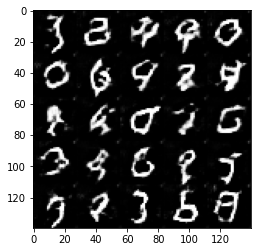

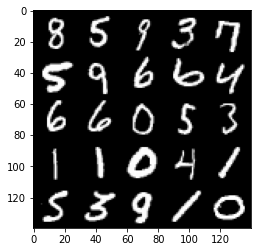

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 0.7499270943403246, Discriminator loss: 0.6714380995035173


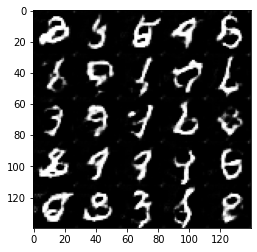

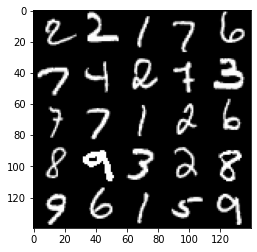

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 0.7502137792110443, Discriminator loss: 0.671850032925606


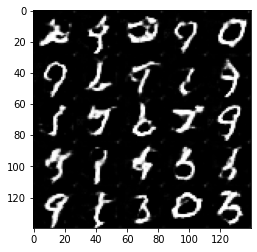

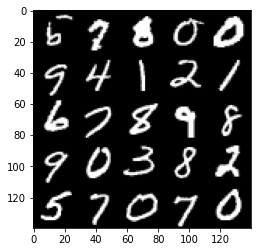

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 0.748284107446671, Discriminator loss: 0.6718063837289808


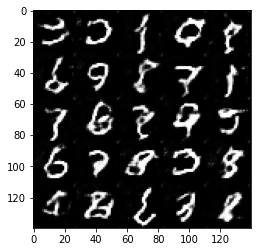

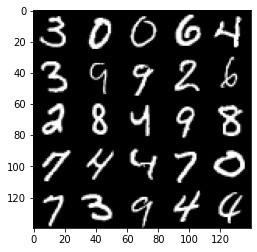

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 0.7496020810604105, Discriminator loss: 0.6717984468936921


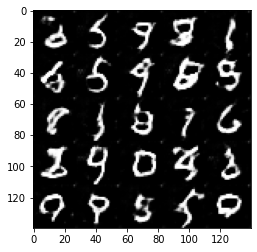

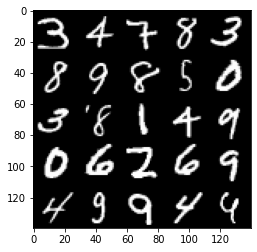

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 0.7513642315864553, Discriminator loss: 0.6711270070075991


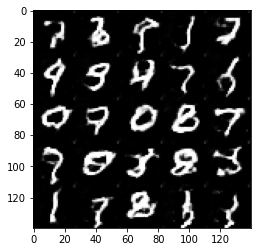

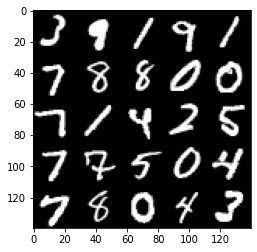

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 0.7504167228937153, Discriminator loss: 0.6721622331142426


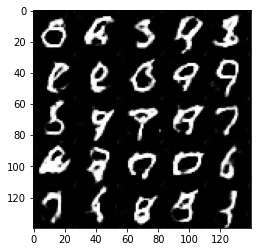

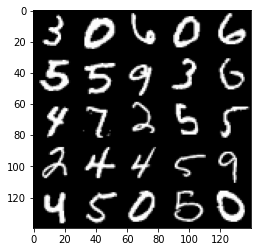

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 0.7525844383239745, Discriminator loss: 0.6714211529493335


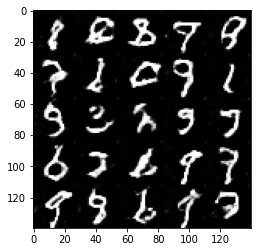

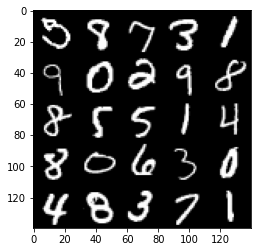

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 0.7508342807292935, Discriminator loss: 0.6728356301784513


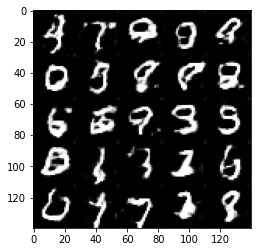

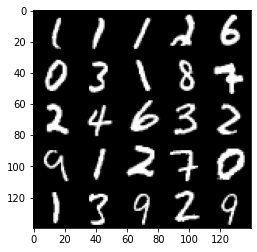

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 0.7500853350162507, Discriminator loss: 0.672868477344513


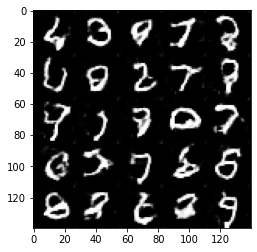

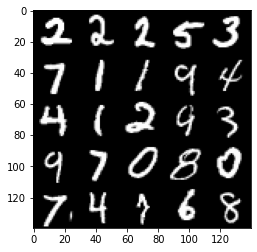

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 0.7484239553213119, Discriminator loss: 0.6740256245136259


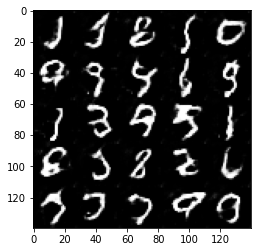

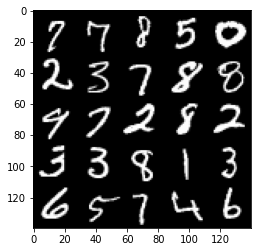

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 0.7459184393882753, Discriminator loss: 0.6751617628335952


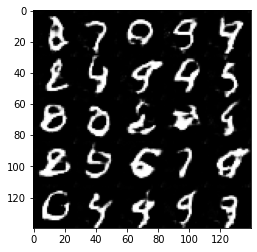

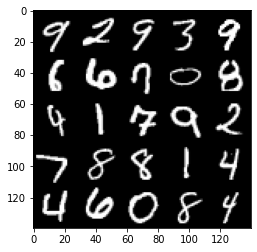

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 0.7467605243921275, Discriminator loss: 0.6754238326549524


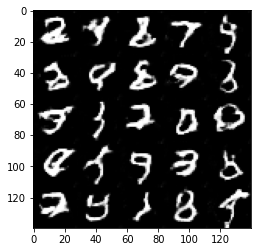

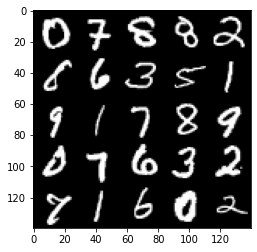

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 0.7445007560253137, Discriminator loss: 0.6756608723402039


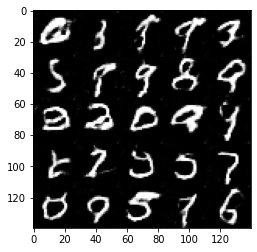

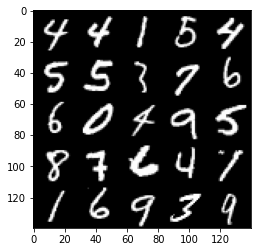

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 0.7454367691278461, Discriminator loss: 0.6755282573699957


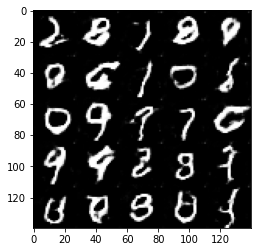

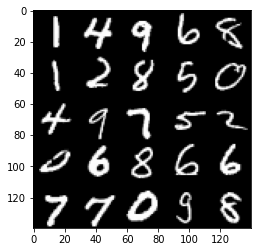

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 0.7469162502288813, Discriminator loss: 0.6741880335807798


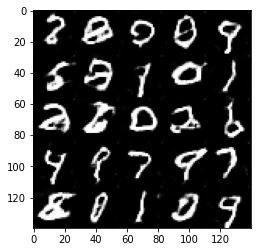

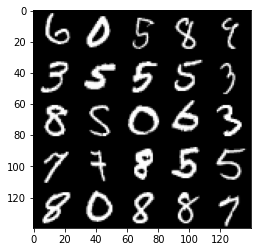

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 0.7460725820064543, Discriminator loss: 0.6741074693202973


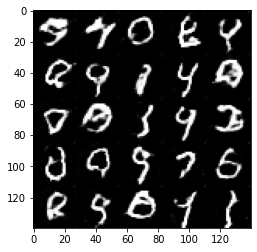

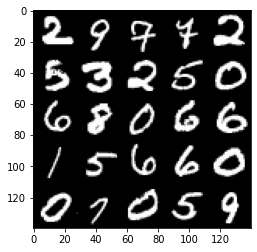

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 0.7441676367521288, Discriminator loss: 0.676086399674415


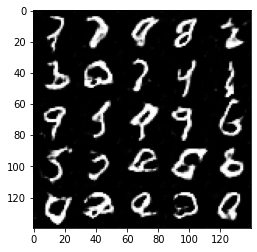

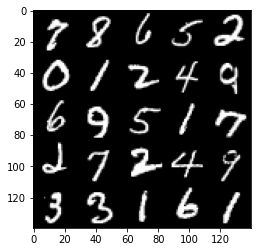

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 0.7441874915361407, Discriminator loss: 0.6764215464591982


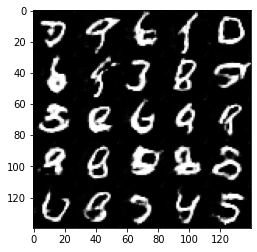

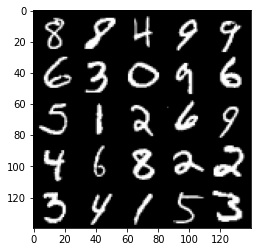

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: 0.7440861799716958, Discriminator loss: 0.6760823646783828


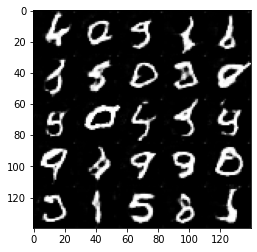

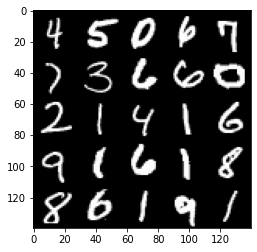

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: 0.7431254502534864, Discriminator loss: 0.6750365128517145


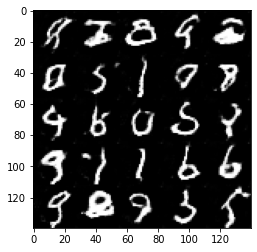

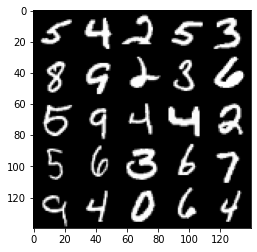

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: 0.7446680588722226, Discriminator loss: 0.6755201413631435


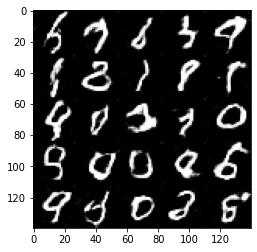

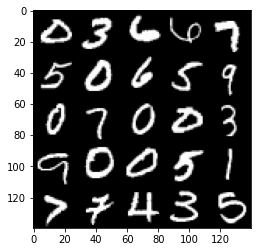

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: 0.7442241353988648, Discriminator loss: 0.6747954846620561


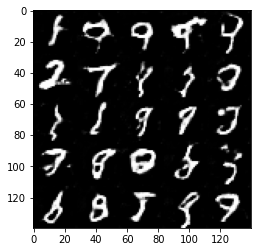

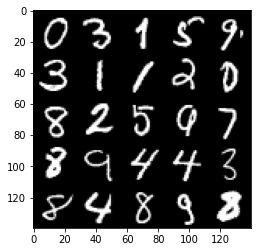

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: 0.7449607197046276, Discriminator loss: 0.6753317497968682


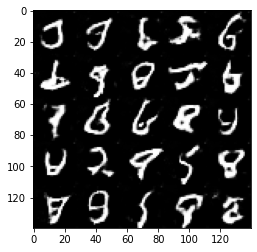

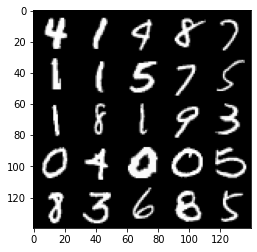

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: 0.7417248266935343, Discriminator loss: 0.675941913366318


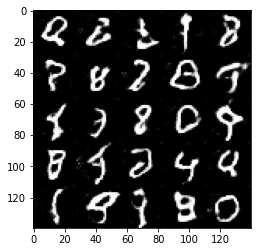

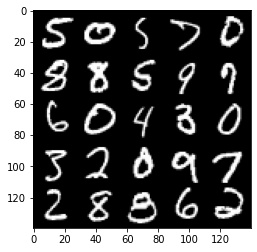

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: 0.7446319324970242, Discriminator loss: 0.6757480474710459


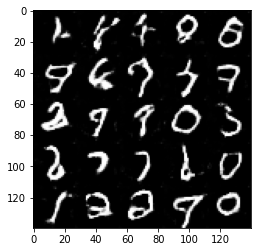

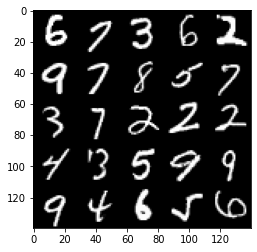

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: 0.7440007772445683, Discriminator loss: 0.6747575815916065


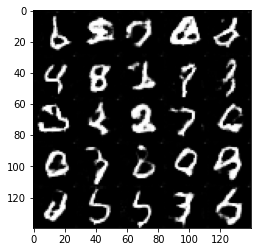

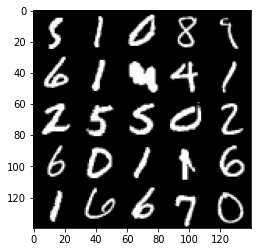

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 0.7425787121057508, Discriminator loss: 0.6763520109653466


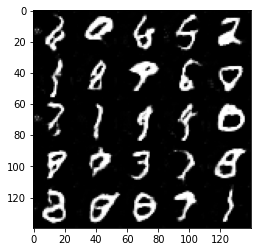

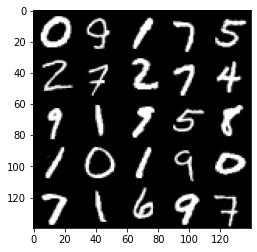

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: 0.7402921446561819, Discriminator loss: 0.6771467136144635


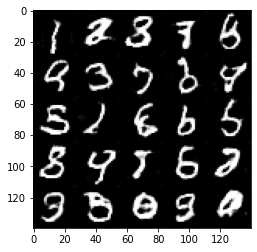

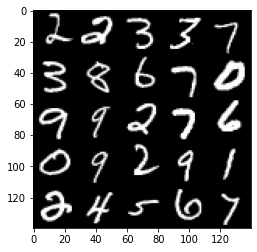

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: 0.7395981506109236, Discriminator loss: 0.6770593439340594


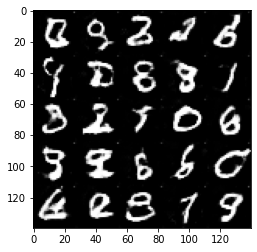

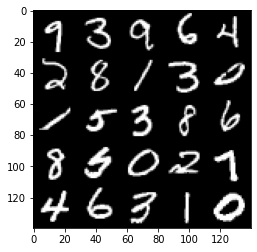

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: 0.7393396327495577, Discriminator loss: 0.6772156200408931


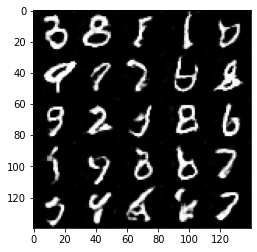

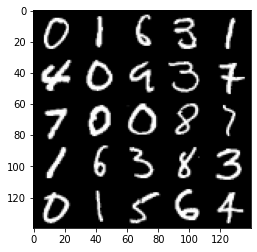

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: 0.7380695490837086, Discriminator loss: 0.6767362316846849


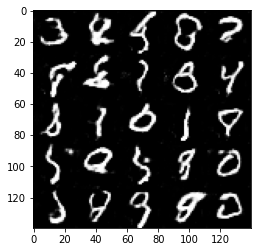

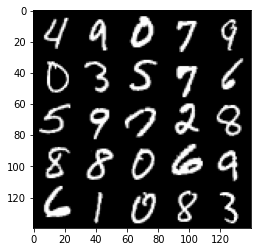

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: 0.7390582054853441, Discriminator loss: 0.677861560344696


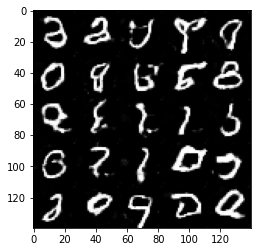

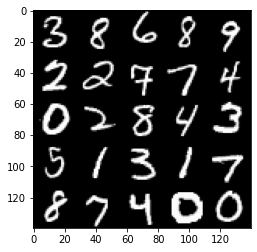

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: 0.7391336830854416, Discriminator loss: 0.6764915512800221


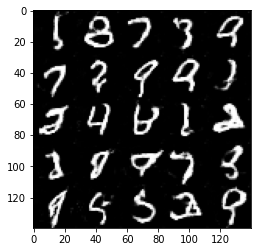

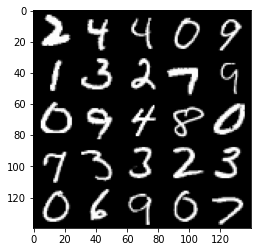

In [10]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real in tqdm(train_dataset):
        cur_batch_size = len(real)
        noise = get_noise(cur_batch_size, z_dim)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake = gen(noise, training=True)

            real_output = disc(real, training=True)
            fake_output = disc(fake, training=True)

            gen_loss = BCELoss(tf.ones_like(fake_output), fake_output)
            disc_loss = (BCELoss(tf.ones_like(real_output), real_output) + BCELoss(tf.zeros_like(fake_output), fake_output)) / 2
        
        grads_of_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
        grads_of_disc = disc_tape.gradient(disc_loss, disc.trainable_variables)

        gen_opt.apply_gradients(zip(grads_of_gen, gen.trainable_variables))
        disc_opt.apply_gradients(zip(grads_of_disc, disc.trainable_variables))

        mean_discriminator_loss += disc_loss.numpy() / display_step
        mean_generator_loss += gen_loss.numpy() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f'Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}')
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1